# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

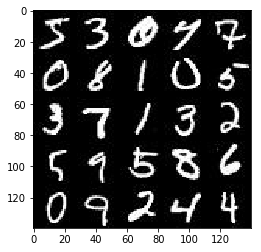

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

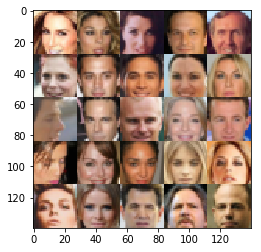

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out_discriminator = tf.sigmoid(logits)
        
        return out_discriminator, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    training=True
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size=5, strides=1, padding='SAME')
        # 28x28x3 now
        
        out_generator = tf.tanh(logits)
        
        return out_generator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    discriminator_loss = d_loss_real + d_loss_fake

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    
    if data_image_mode == "RGB":
        out_channel_dim = 3
    elif data_image_mode == "L":
        out_channel_dim = 1

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    #Print the current image
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 1.8887
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.6207
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.4813


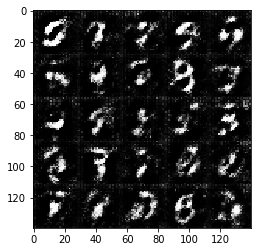

Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.2982
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.0546


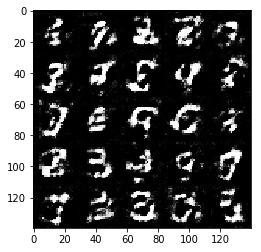

Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 1.1148


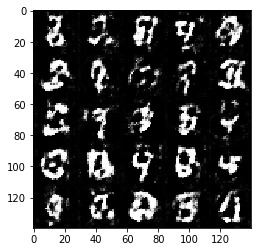

Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.0438
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 1.7469
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 1.5042
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.8107
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.7545


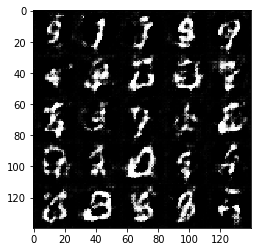

Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.1574
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 2.1413
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 1.8768
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.1619
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 0.8309


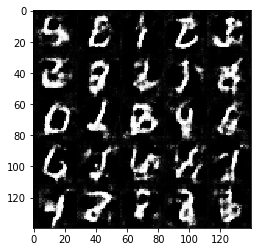

Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 1.5086
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 1.8346
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.2881


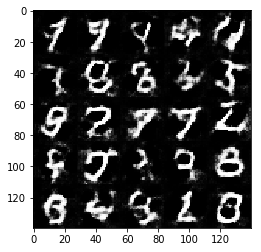

Epoch 1/2... Discriminator Loss: 0.8564... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.3955
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.3169
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.1325
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 1.1181
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.6952


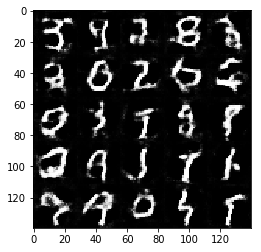

Epoch 1/2... Discriminator Loss: 1.6108... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 1.5904
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 1.3077
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.5833
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.6627


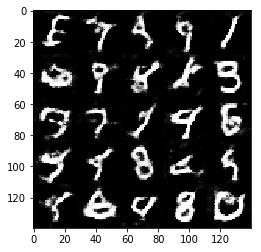

Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 1.5970
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.0108


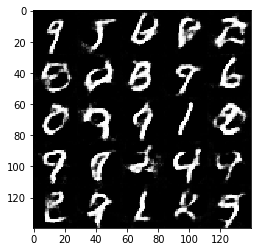

Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.9041... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 1.5574


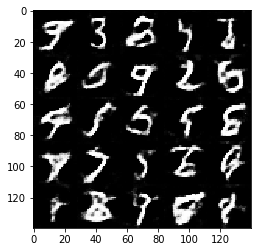

Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.6368
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.1243
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 0.9586


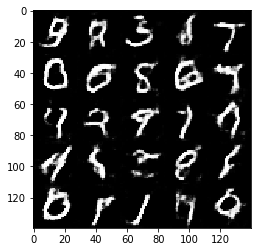

Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.0929
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 0.8643... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.8531


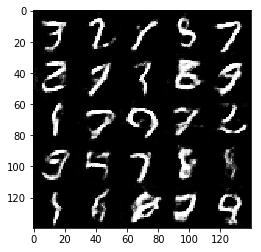

Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.6720
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.4496
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.6052
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.8414


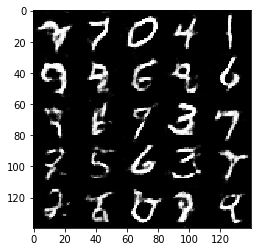

Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.3154
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.7602... Generator Loss: 1.5410
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.5218


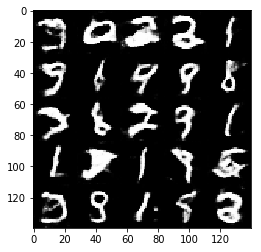

Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.4940
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.7375


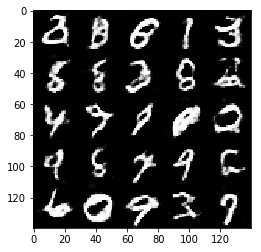

Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 0.6135... Generator Loss: 1.2659
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.3462
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.7256
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.6243


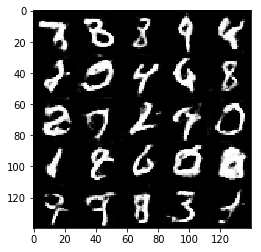

Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.4223
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.0143
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.4853
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.5728


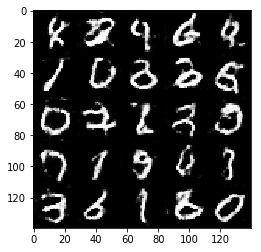

Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 1.8267
Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 0.3712


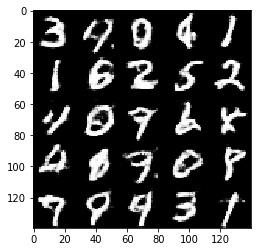

Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.3599
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.4100
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.3049


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7668... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.7538
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 2.3948


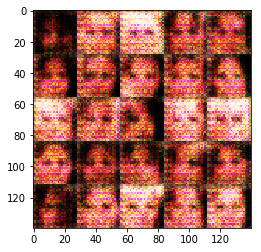

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 2.6072
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 2.9780
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 0.7908


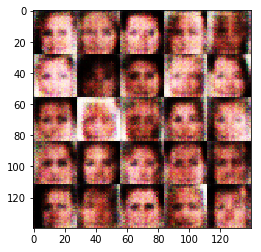

Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 3.1474
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 0.2914... Generator Loss: 2.5866
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.8659
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.4425
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 2.4489
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.9059


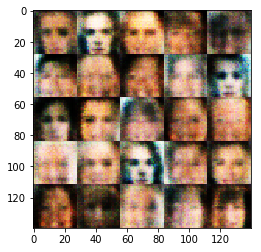

Epoch 1/1... Discriminator Loss: 0.2930... Generator Loss: 3.4439
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.3593
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.2270
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8024


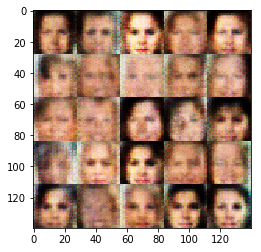

Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.3207
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 4.5568
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 2.4279
Epoch 1/1... Discriminator Loss: 0.2017... Generator Loss: 4.4941
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 4.6385


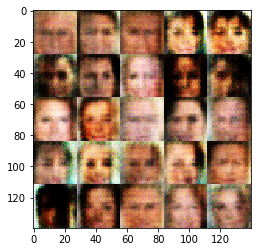

Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 3.8591
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 2.6609
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 6.5415
Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 3.9894


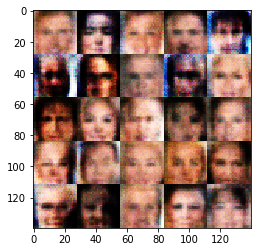

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 5.7430
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 6.5933
Epoch 1/1... Discriminator Loss: 0.2662... Generator Loss: 2.3694
Epoch 1/1... Discriminator Loss: 2.0184... Generator Loss: 0.1847
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 4.7713
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.6335


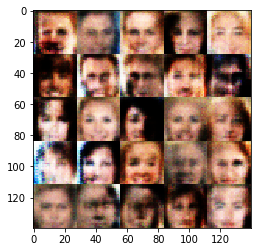

Epoch 1/1... Discriminator Loss: 0.1511... Generator Loss: 5.9928
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 4.1896
Epoch 1/1... Discriminator Loss: 0.1604... Generator Loss: 6.9922
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.2635... Generator Loss: 4.5158
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 6.5544
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 7.0040
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 3.6143


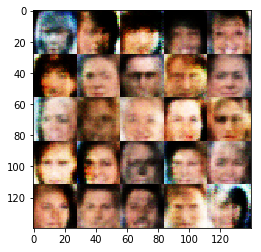

Epoch 1/1... Discriminator Loss: 0.2670... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 0.1690... Generator Loss: 5.8515
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 1.8375
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 3.3700
Epoch 1/1... Discriminator Loss: 0.1505... Generator Loss: 5.2623
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 3.7454


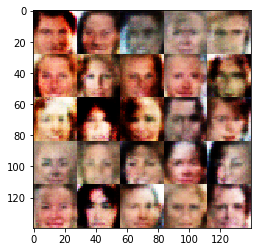

Epoch 1/1... Discriminator Loss: 0.2594... Generator Loss: 1.9159
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 6.5604
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 4.9149
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.6005
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 4.0653
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 1.9217
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.6166
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.5349


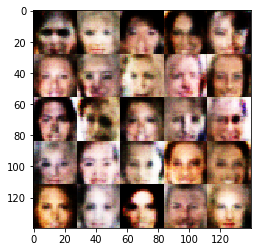

Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 3.2902
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 6.1855
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 2.9179
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 5.4495
Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 3.2214
Epoch 1/1... Discriminator Loss: 2.2339... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.3276


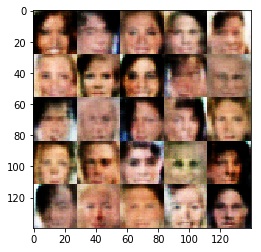

Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 2.8794
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 2.3914
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 2.0044
Epoch 1/1... Discriminator Loss: 0.2161... Generator Loss: 3.6643
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 3.3150
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 1.7067
Epoch 1/1... Discriminator Loss: 0.2127... Generator Loss: 2.3877


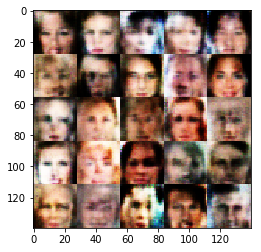

Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 4.5754
Epoch 1/1... Discriminator Loss: 0.2150... Generator Loss: 4.1458
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 2.5728
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 3.1281
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 3.7575
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 4.3744
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 3.8625


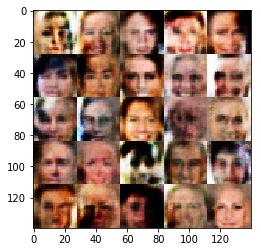

Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 2.2158
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 0.2144... Generator Loss: 5.1188
Epoch 1/1... Discriminator Loss: 0.1201... Generator Loss: 6.5798
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 3.4136
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 4.6660
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.7941
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 5.7431


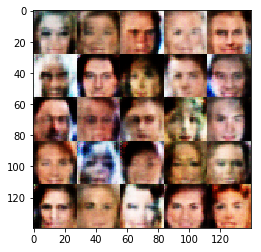

Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.1865
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 6.0666
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 4.6924
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 4.5731
Epoch 1/1... Discriminator Loss: 0.1761... Generator Loss: 4.9573
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 5.8700
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 4.6189


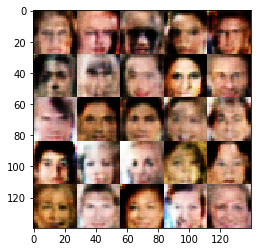

Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.1729
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 4.2464
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 4.7986
Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 6.0552
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 0.2461... Generator Loss: 2.2468
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 3.2551


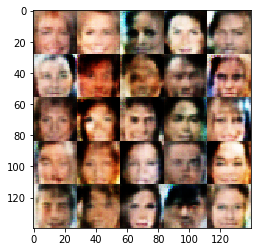

Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 4.8596
Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 4.3928
Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.7733
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 4.2127
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 6.4873
Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 2.2702
Epoch 1/1... Discriminator Loss: 0.1669... Generator Loss: 3.4738
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 1.5295


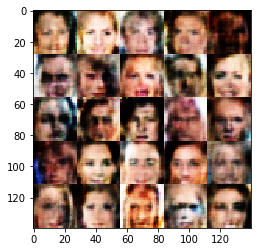

Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 0.2652... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 6.9269
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 4.9349
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 3.0914
Epoch 1/1... Discriminator Loss: 0.2378... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.7648
Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 2.4029


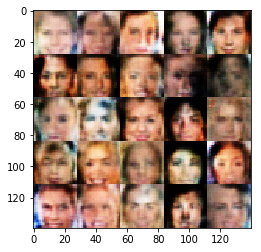

Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.4024
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 5.2774
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 2.9848
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.4079
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 3.2595
Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 6.7362
Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 3.4683


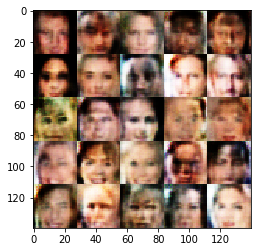

Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 5.0461
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 2.3607
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 4.2456
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 3.6145
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 2.5856
Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 2.6224


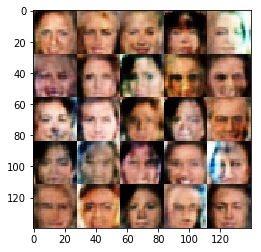

Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 2.5721
Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 2.9340
Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 5.9485
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 4.6100
Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 3.9651
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.5709
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 0.1581... Generator Loss: 3.7875
Epoch 1/1... Discriminator Loss: 0.1190... Generator Loss: 3.6958


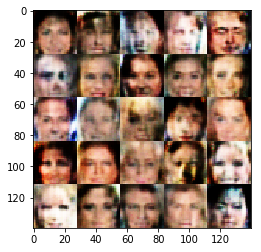

Epoch 1/1... Discriminator Loss: 0.0799... Generator Loss: 6.5697
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 2.6766
Epoch 1/1... Discriminator Loss: 2.3480... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 0.2159... Generator Loss: 2.6865
Epoch 1/1... Discriminator Loss: 0.2374... Generator Loss: 2.9973
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 2.7967
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 3.5371
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.2809
Epoch 1/1... Discriminator Loss: 0.2080... Generator Loss: 5.4601
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 5.0046


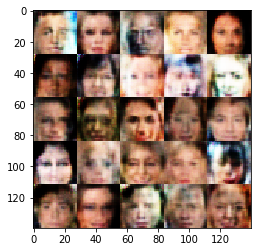

Epoch 1/1... Discriminator Loss: 0.2016... Generator Loss: 3.0881
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 2.6992
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 5.3163
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.8891
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 5.4067
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 4.8952
Epoch 1/1... Discriminator Loss: 0.0720... Generator Loss: 4.2210
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 4.7884
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 2.3745


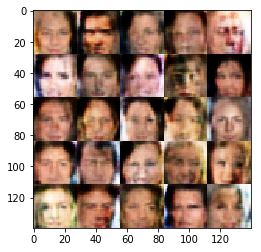

Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 4.6359
Epoch 1/1... Discriminator Loss: 0.0748... Generator Loss: 4.5189
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 4.0962
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 2.7381
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 2.9116
Epoch 1/1... Discriminator Loss: 0.2155... Generator Loss: 2.6480
Epoch 1/1... Discriminator Loss: 2.0875... Generator Loss: 0.2471
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 3.5319
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 1.9686


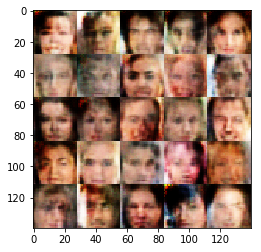

Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.1062
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.9758
Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 3.2477
Epoch 1/1... Discriminator Loss: 0.2907... Generator Loss: 1.9631
Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 3.8580
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 4.8563
Epoch 1/1... Discriminator Loss: 0.2692... Generator Loss: 3.9509
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.9804
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 4.0201
Epoch 1/1... Discriminator Loss: 0.2270... Generator Loss: 7.7111


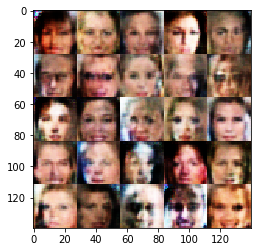

Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 2.8671
Epoch 1/1... Discriminator Loss: 0.2374... Generator Loss: 2.3902
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 3.5310
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.8054
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 2.7883
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 2.4167
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 3.8962
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 4.6577
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 1.8016
Epoch 1/1... Discriminator Loss: 0.1354... Generator Loss: 3.2649


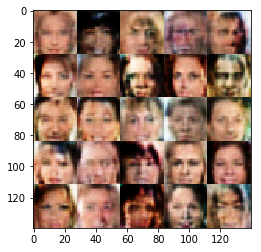

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.